<a href="https://colab.research.google.com/github/marttech26/EY-Open-Science-Data-Challenge/blob/main/Challenge_2024_Landsat_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2024 Open Science Data Challenge
### Landsat Vegetation Change with Cloud Filtering

This notebook calculates pixel-based vegetation change using Landsat optical data with cloud filtering. In order to identify regions where there is land change due to a tropical storm this code uses the Normalized Difference Vegetation Index (NDVI) which is commonly used to meausure vegetation extent and health. For example, this code will find areas where trees have fallen, tree leaves have been removed by high winds, grasslands have been flooded, or agriculture fields have been damaged. The outputs of this notebook can be used to identify storm-damaged vegetation areas and nearby regions that are likely to have significant building damage. The baseline data is [Landsat Collection-2 Level-2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data from the MS Planetary Computer catalog.

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms
from matplotlib.cm import RdYlGn, Reds

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba

### Load the satellite data

First, we define our area of interest using latitude and longitude bounds. This is the region where the data challenge is focused and where the most extensive damage can be found. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates. Finally, we define the time window surrounding the storm landfall on September 20, 2017. Due to cloud cover, we will need to search well before and well after the storm to find good scenes with minimal cloud cover. As you will see, Puerto Rico is a very cloudy location.

In [ ]:
# Hurricane Maria - San Juan, Puerto Rico

# Define the bounding box for the entire data region
min_lon = -66.19385887
min_lat = 18.27306794
max_lon = -66.08007533
max_lat = 18.48024350

In [ ]:
# Calculate the bounds for doing an archive data search
bounds = (min_lon, min_lat, max_lon, max_lat)

In [ ]:
# Define the time window
time_window = "2017-06-15/2017-11-15"

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. To avoid issues with Landsat-7 data, we have only included data from Landsat-8 and Landsat-9 missions.

In [ ]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"],
    bbox=bounds,
    datetime=time_window,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 27


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The ODC [odc](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands, reproject into Lat-Lon coordinates (EPSG:4326) at 30-meters resolution (typical of Landsat pixel resolution), and clip the region to the spatial bounding box.

In [ ]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for CRS:4326

### Landsat Band Summary
Red = 0.66 um
<br>Green = 0.56 um
<br>Blue = 0.48 um
<br>NIR (nir08) = 0.84 um

In [ ]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

In [ ]:
# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2

In [ ]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset>
Dimensions:      (latitude: 770, longitude: 423, time: 27)
Coordinates:
  * latitude     (latitude) float64 18.48 18.48 18.48 ... 18.27 18.27 18.27
  * longitude    (longitude) float64 -66.19 -66.19 -66.19 ... -66.08 -66.08
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2017-06-22T14:43:47.156698 ... 2017-11...
Data variables:
    red          (time, latitude, longitude) float64 dask.array<chunksize=(1, 770, 423), meta=np.ndarray>
    green        (time, latitude, longitude) float64 dask.array<chunksize=(1, 770, 423), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 dask.array<chunksize=(1, 770, 423), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 dask.array<chunksize=(1, 770, 423), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 dask.array<chunksize=(1, 770, 423), meta=np.ndarray>

### View RGB (real color) images from the time series

Data is available for Landsat-8 from April-2013 to now. Data is available for Landsat-9 from Feb-2022 to now. So, for the selected time window and missions there are typically views of our region every 8 days.
<br><br>You will notice that many of the scenes have clouds and some of the scenes are "clipped" due to scene boundaries. In general we want to look for scenes that fill the ROI bounds with clear data. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above.  

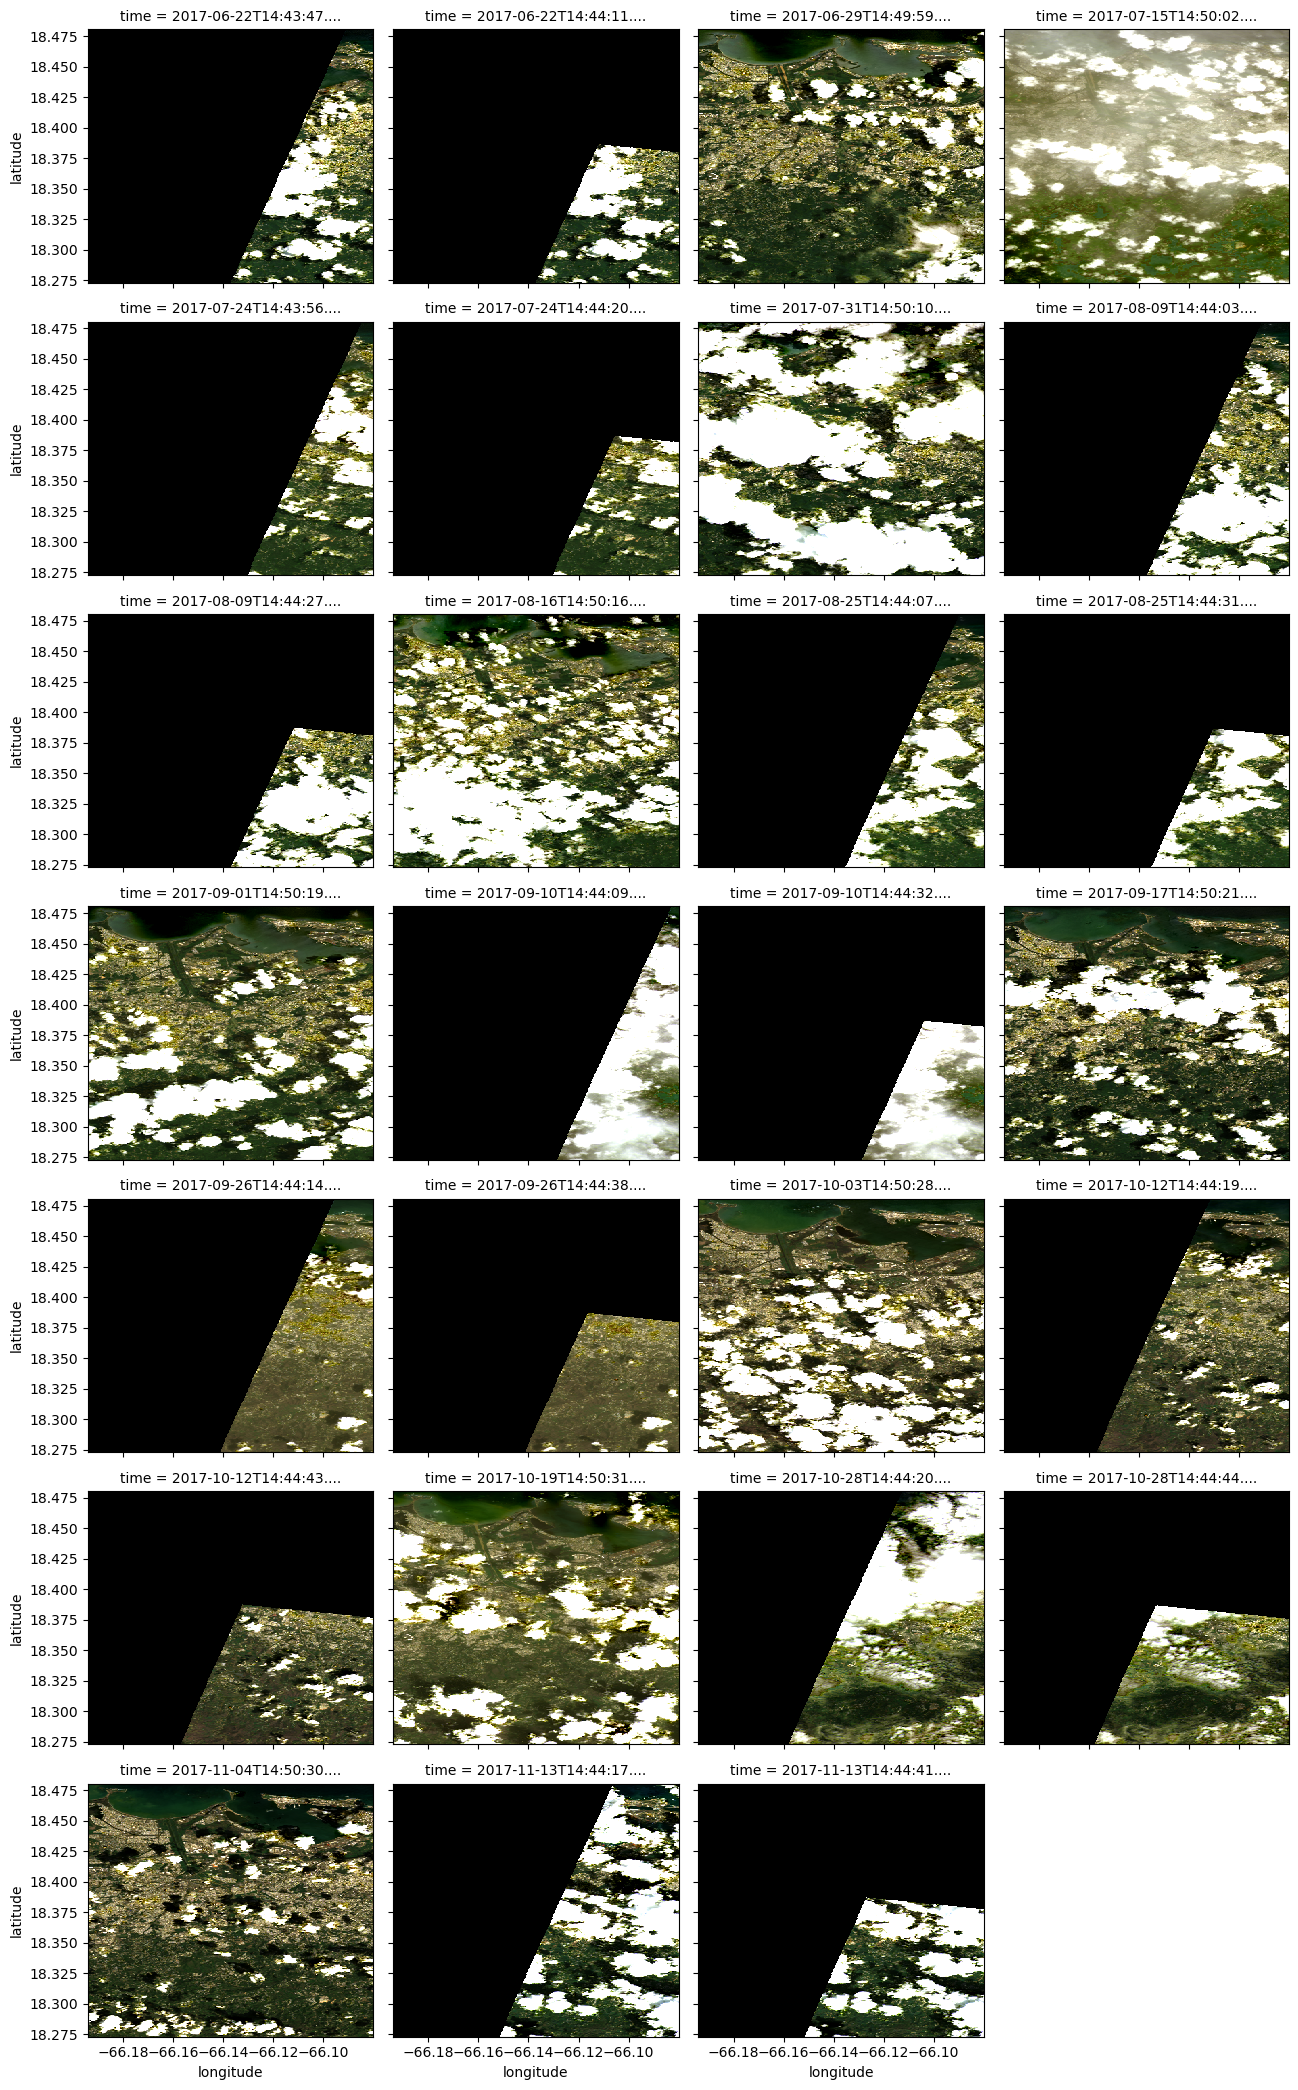

In [ ]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

In [ ]:
# Select a time slice to view a simple RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

time_slice = 2 # June 29, 2017 (post-storm)

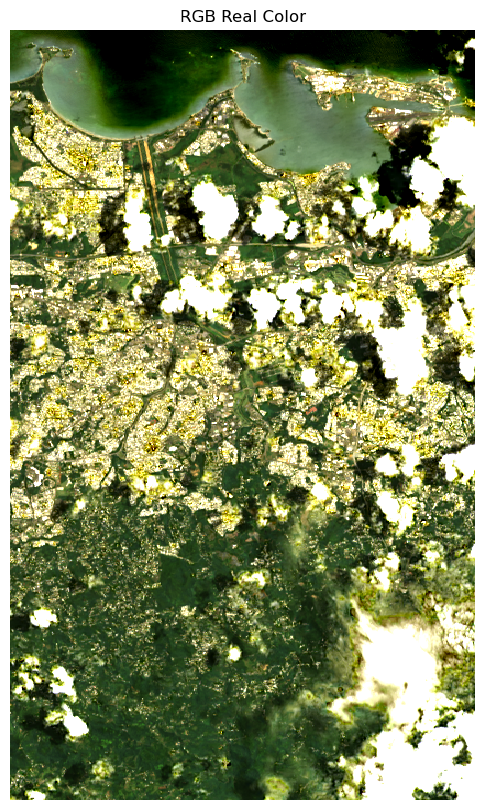

In [ ]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(6,10))
plot_xx.isel(time=time_slice).plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.2)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

Cloud masking for Landsat Collection-2 Level-2 data can be complicated. The <b>"qa_pixel"</b> band is used to assess each pixel and determine its cloud or water classification. The code below is credited to Mauricio Cordiero. See his webpage [HERE](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for a more detailed explanation of the process. Also, you can visit the Landsat-8 Collection-2 Level-2 Product Guide [HERE](https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide) for more details about the cloud mask values. In the end, we are searching for clouds, cloud shadows, and water to create a mask for any given region. This will allow us to extract the "clear" pixels to assess the vegetation state.

In [ ]:
# To mask the pixels and find clouds or water, it is best to use the bit values of the 16-bit qa_pixel flag
# See the website above for a nice explanation of the process

bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2,
            'cloud': 1<<3,
            'shadow': 1<<4,
            'snow': 1<<5,
            'clear': 1<<6,
            'water': 1<<7
}

In [ ]:
# Create a function that will mask pixels with a given type

def get_mask(mask, flags_list):

    # Create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)

    # Loop through the flags
    for flag in flags_list:

        # get the mask for each flag
        flag_mask = np.bitwise_and(mask, bit_flags[flag])

        # add it to the final flag
        final_mask = final_mask | flag_mask

    return final_mask > 0

In [ ]:
# Pick a single time slice to view a mask with clouds and water
sample_xx = xx.isel(time=time_slice)

In [ ]:
# Find the pixels that are no data (fill), clouds, cloud shadows, or water
my_mask = get_mask(sample_xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])

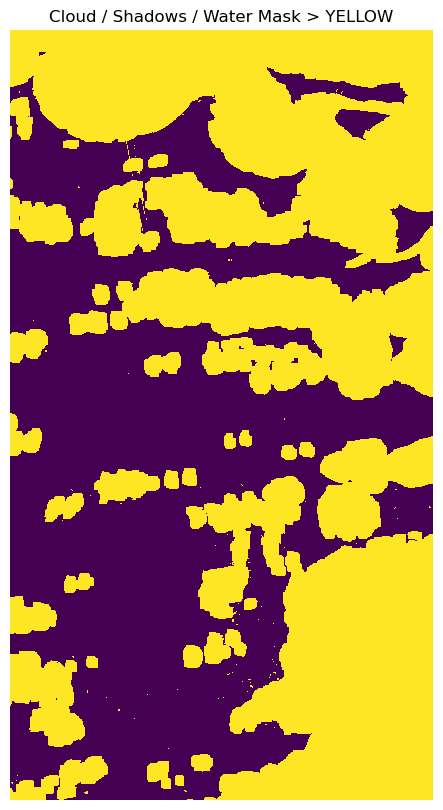

In [ ]:
# Show only the mask (Yellow) with valid data in Purple
plt.figure(figsize=(6,10))
plt.imshow(my_mask)
plt.title("Cloud / Shadows / Water Mask > YELLOW")
plt.axis('off')
plt.show()

In [ ]:
# Create an RGB function that will display the mask over the background RGB image

def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):

    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness

    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)

    rgb = np.stack([red, green, blue], axis=2)

    return rgb

In [ ]:
rgb = plot_masked_rgb(sample_xx['red'], sample_xx['green'], sample_xx['blue'], my_mask, color_mask=(1, 0, 1), transparency=0.2, brightness=3)

In [ ]:
# Clip data to avoid plotting errors
rgb = np.clip(rgb,0,1)

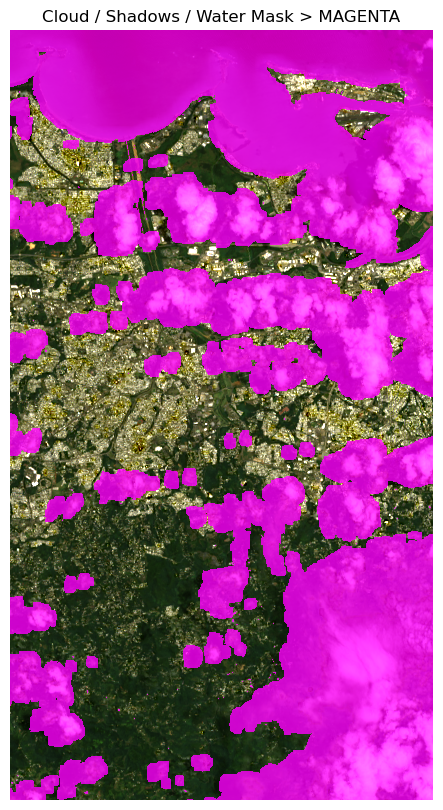

In [ ]:
# This is a nice image that shows the clouds and water pixels (Purple) among clear land pixels
plt.figure(figsize=(6,10))
plt.imshow(rgb)
plt.title("Cloud / Shadows / Water Mask > MAGENTA")
plt.axis('off')
plt.show()

### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, water, trees without leaves), middle values (0.25 to 0.6) reflect grasslands or light vegetation, and high values (0.6 to 1.0) reflect dense forests. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [ ]:
# Define the two time steps to view and compare NDVI outputs
first_time = 2 # June 29, 2017
second_time = 24 # November 4, 2017

In [ ]:
# Calculate the mask for the entire xarray (all time slices)
full_mask = get_mask(xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])

In [ ]:
# Create a "clean" dataset with the mask applied
cleaned_data = xx.where(~full_mask)

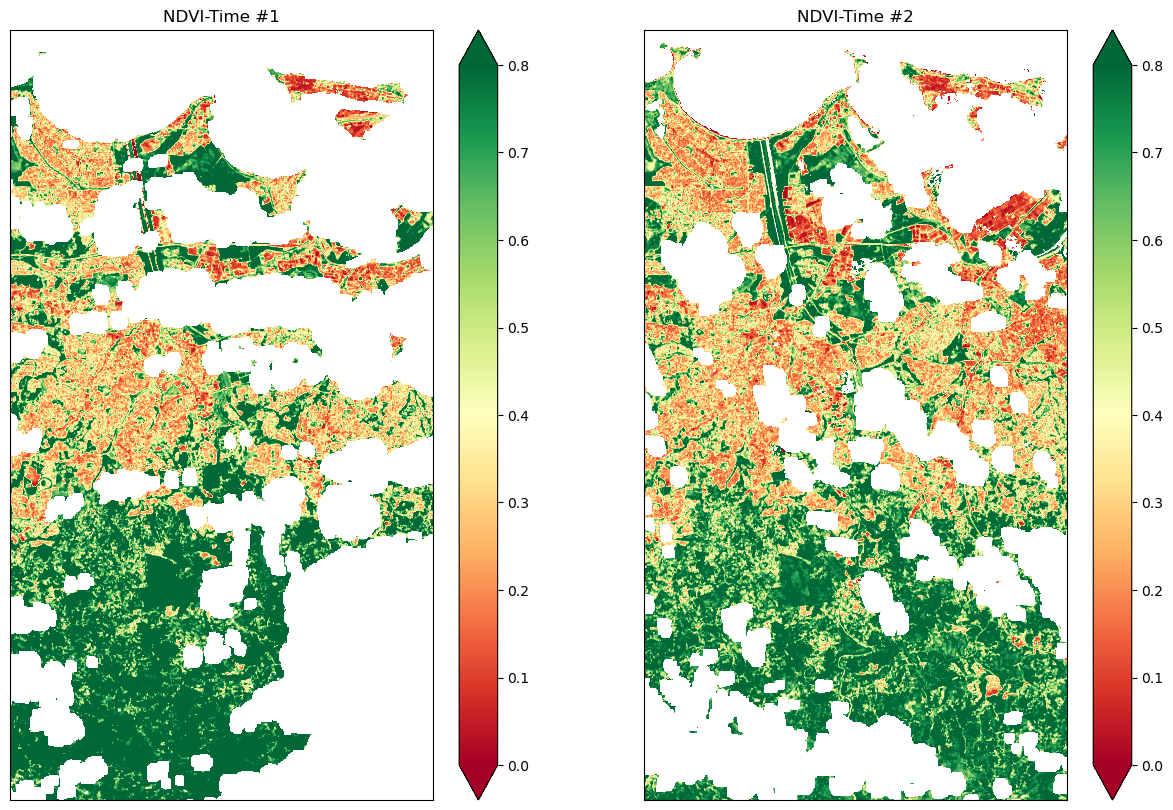

In [ ]:
# Plots of NDVI at two different time slices
# Clouds, Shadows and Water are masked

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ndvi_image = (cleaned_data.nir08-cleaned_data.red)/(cleaned_data.nir08+cleaned_data.red)
ndvi_image.isel(time=first_time).plot(ax=ax[0], vmin=0.0, vmax=0.8, cmap="RdYlGn")
ndvi_image.isel(time=second_time).plot(ax=ax[1], vmin=0.0, vmax=0.8, cmap="RdYlGn")
ax[0].set_title('NDVI-Time #1'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('NDVI-Time #2'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

### NDVI Change Product
Calculate an NDVI anomaly by comparing the two images. Mask all areas of clouds and water that part of either image.

In [ ]:
def NDVI(dataset):
    return (dataset.nir08 - dataset.red)/(dataset.nir08 + dataset.red)

In [ ]:
ndvi_clean = NDVI(cleaned_data)

In [ ]:
ndvi_pre = ndvi_clean.isel(time=first_time)
ndvi_post = ndvi_clean.isel(time=second_time)
ndvi_anomaly = ndvi_post - ndvi_pre

In [ ]:
# Set colormap values for mask
# All areas of water or clouds will be black
RdYlGn.set_bad('black',1.)

In [ ]:
# Reverse the colormap for reds
Reds_reverse = "Reds_r"

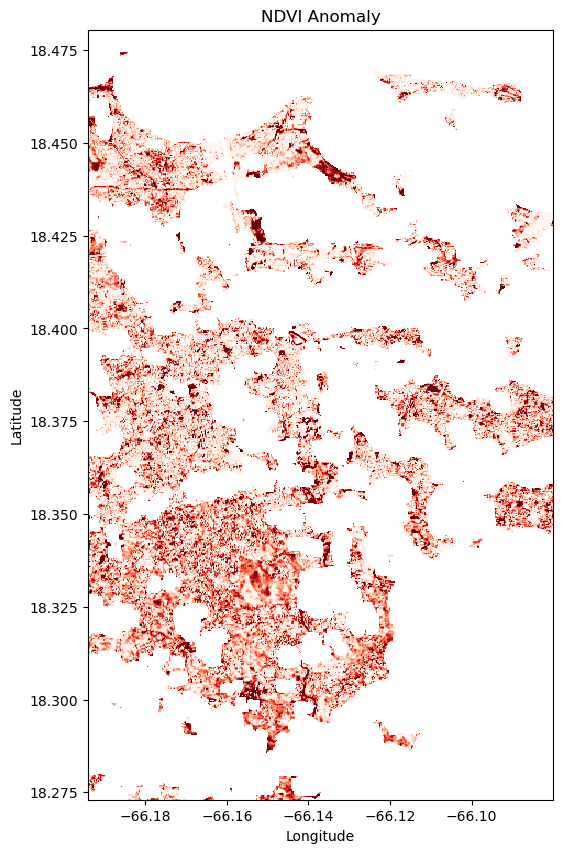

In [ ]:
## Plot NDVI Anomaly
plt.figure(figsize = (6,10))
ndvi_anomaly.plot(vmin = -0.2, vmax=0.0, cmap = Reds_reverse, add_colorbar=False)
plt.title("NDVI Anomaly")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.axis('off')
plt.show()

<b>COMMENTS ON RESULTS:</b> The results above show many areas where vegetation has been lost or severely reduced. These areas have a reduced NDVI value of 0.2 or more given a normal range of 0 to 1.0. This amount of loss is typical for severe vegetation change due to a storm or fire. Areas of white color are masked regions where there are clouds or water in either image. As you can see, there are many clouds in these images but they represent the best available images before and after the storm. It is also important to note that Puerto Rico has a consistent annual climate so vegetation change during a year is minimal. Therefore, it is possible to compare images from different times of the year and still detect valid change. So, how might participants use this data? Buildings near areas where there is significant land change (dark red) are likely to see some of the highest levels of damage.